# Preliminary study on VLLS and VLLD yields

I am considering the 2018 scenario with luminosity 59.8 fb$^{-1}$. I am investigating the singlet as well as the doublet models of VLL in purely electron like, and purely muon like scenarios. The following are the final states that I am interested in.
- 4L (inclusive)
- Exactly 3L
- Exactly 2L (OS and SS)
- Exactly 1L and XJ (X = 2+, 1, 0)
  
These final states are orthogonal to each other and the filling order does not matter.

### Object and event selections
I am picking medium ID electrons and muon as L with pT>10 and fabs(eta)<2.4 <br>
The Jets have pT>30 and abs(eta)<2.3 with standard selections.<br>
These reco objects are dR-cleaned by 0.5 from each other. The jets are also cleaned from standard taus.<br>
Here is a link to the details of object selections - https://github.com/phazarik/VLLSearch-Run3/blob/main/Setup/ProduceRecoCollection.h <br>
Here is a link to the details of event selections - https://github.com/phazarik/VLLSearch-Run3/blob/prachu_2LSS/Setup/EventSelection.h

### Trigger and cuts
The event should have at least one muon with pT>26 GeV, or one electron with pT>30 GeV. Right now I am not considering whether this lepton should be a part of the final state object or not (for channels containing more than one leptons). **There are no additional cuts right now.** Later, more cuts will be put on the individual channels to purify signals, which will bring down the acceptance and yield.

### Corrections for the doublet models
The VLLD models contain some <span style="color:red;">invalid</span> decay modes which are mentioned below.<br>
<div style="text-align:center;">
    $L\rightarrow W\nu_\tau$<br>
    $N\rightarrow H\nu_\tau, Z\nu_\tau$
</div>
We calculate acceptance by doing <code>nevt_in_channel/nevt_in_file</code>. However, in this case, the denomnator itself is reducing because of the event flag I used to get rid of these invalid decays. However, the effect on the numerator may not be the same. That's why I expect the numbers to be differnt from that of Yash. These is no such modification to the singlet models.

In [1]:
import ROOT
import os, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Welcome to JupyROOT 6.26/10


In [2]:
signal_file = 'signal_database.json'
with open(signal_file, 'r') as file: json_data = json.load(file)
print('Signal database loaded!')

datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')
print('Plot directory ready!')

thin_line = {
    'marker':'o',
    'linestyle':'--',
    'markersize':3,
    'linewidth':1
}
thick_line = {
    'marker':'o',
    'linestyle':'-',
    'markersize':4,
    'linewidth':2
}

masses = [100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 600, 750, 800, 1000]

def accp(num, den):
    if den==0 : return 0
    else : return (num/den)*100

def lumiscale(lumi):
    datalumi = 59800
    scale = datalumi/lumi
    return scale

def put_text(ax):
    ax.text(0, 1.03, "CMS", transform=ax.transAxes, fontsize=12, fontweight='bold')
    ax.text(0.16, 1.03, "preliminary", transform=ax.transAxes, fontsize=12, fontstyle='italic')

Signal database loaded!
Plot directory ready!


#### Preparing the function to fillup a dictionary with acceptance and yields across the mass-points

In [3]:
def check_yields(model):
    plotdict = {
        '1L0J':{'color':'yellow',},
        '1L1J':{'color':'gold'},
        '1L2J':{'color':'orange'},
        '2LOS':{'color':'blue'},
        '2LSS':{'color':'cyan'},
        '3L'  :{'color':'green'},
        '4L'  :{'color':'red'}
    }

    print(f'Yield (acceptance %) for {model} :')
    print(f'mass\tnRAW\tn1L0J\t\tn1L1J\t\tn1L2J\t\tn2LOS\t\tn2LSS\t\tn3L\t\tn4L')
    
    for mass in masses:
        for key, val in json_data.items():
            if key == model:
                filename = f'../input_files/hst_{model}_M{str(mass)}.root'
                file_exists = os.path.exists(filename)
                
                if file_exists:
                    tfile = ROOT.TFile(filename)
                    hist = tfile.Get(f'finalstates_incldecay')
                    nall = hist.GetBinContent(1)
                    
                    print(f'\n{mass}\t{int(nall)}', end='\t')
                    
                    # For each final state:
                    for index, channel in enumerate(plotdict.keys()):
                        plotdict[channel][mass] = {}
                        
                        nchannel = hist.GetBinContent(index+2)
                        acceptance = accp(nchannel, nall)
                        masspoint = 'M' + str(mass)
                        lumi = json_data[model][masspoint].get("lumi", {})
                        scale = lumiscale(lumi)
                        nyield = int(nchannel * scale)
                        
                        # Putting these information in the dictionary: 
                        plotdict[channel][mass]['acceptance'] = acceptance
                        plotdict[channel][mass]['yield'] = nyield

                        #Printing out the numbers per channel:
                        print(f'{int(nyield)} ({acceptance:.1f}%)', end='\t')
                        
                        #break  # channelloop
                else :#If the file does not exists, delete the key
                    #print(f"{filename} not found ... removing mass {mass} from the dictionary" )
                    pass
                    
        #break  # Mass loop
    return plotdict
print('Dictionary maker ready!')

Dictionary maker ready!


#### Plotmaker:

In [4]:
def make_plot(model):
    plotdict_model = {}
    plotdict_model = check_yields(model)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f'{model}', fontsize=16)  # Add a global title
    ax = ax.flatten()

    xaxis = list(plotdict_model['1L2J'].keys())[1:]
    combined_3L4L = [0]*len(xaxis)
    combined_all  = [0]*len(xaxis)
    
    for final_state, data in plotdict_model.items():
        color = data['color']  
        acceptances = [data[mass]['acceptance'] for mass in xaxis]
        ax[0].plot(xaxis, acceptances, label=final_state, color=color, **thin_line)
        combined_all = [sum(x) for x in zip(combined_all, acceptances)]
        if final_state in ['3L', '4L']: combined_3L4L = [sum(x) for x in zip(combined_3L4L, acceptances)]    
    ax[0].plot(xaxis, combined_3L4L, label=f'3L+4L', color='gray',  **thick_line)
    #ax[0].plot(xaxis, combined_all,  label=f'total', color='black', **thick_line)
    #ax[0].set_title(model+" accpetance", fontsize=14)
    ax[0].set_xlabel('Mass (GeV)', fontsize=12)
    ax[0].set_ylabel('Acc*eff (%)', fontsize=12)
    ax[0].set_ylim(0, 100)
    ax[0].set_xlim(0, 1200)
    ax[0].grid(True, alpha=0.5)
    ax[0].legend(loc='best', fontsize=8, ncol=2)
    put_text(ax[0])

    for final_state, data in plotdict_model.items():
        color = data['color']  
        yields = [data[mass]['yield'] for mass in xaxis]
        ax[1].plot(xaxis, yields, label=final_state, color=color, **thin_line)
    #ax[1].set_title(model+" yield", fontsize=14)
    ax[1].set_xlabel('Mass (GeV)', fontsize=12)
    ax[1].set_ylabel('Yield', fontsize=12)
    ax[1].set_xlim(0, 1200)
    ax[1].grid(True, alpha=0.5)
    ax[1].legend(loc='best', fontsize=8, ncol=2)
    put_text(ax[1])
    ax[1].text(0.62, 1.03, "(2018) 59.8 fb$^{-1}$", transform=ax[1].transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/yields_{model}.png', dpi=300)
    plt.show()

print('Plotmaker ready!')

Plotmaker ready!


### Plots for 4 types of models

Yield (acceptance %) for VLLS_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	599740	112 (0.2%)	2078 (3.8%)	6588 (12.2%)	1531 (2.8%)	78 (0.1%)	167 (0.3%)	17 (0.0%)	
125	594714	49 (0.2%)	893 (3.3%)	5186 (19.0%)	1933 (7.1%)	152 (0.6%)	392 (1.4%)	110 (0.4%)	
150	598626	24 (0.2%)	472 (3.6%)	3772 (28.6%)	1457 (11.0%)	104 (0.8%)	259 (2.0%)	84 (0.6%)	
200	598182	7 (0.2%)	148 (3.1%)	1734 (36.4%)	720 (15.1%)	47 (1.0%)	117 (2.5%)	44 (0.9%)	
250	496991	2 (0.1%)	55 (2.6%)	832 (39.4%)	362 (17.2%)	22 (1.1%)	57 (2.7%)	22 (1.1%)	
300	498516	1 (0.1%)	23 (2.2%)	433 (41.1%)	194 (18.4%)	11 (1.1%)	30 (2.8%)	12 (1.2%)	
350	199194	0 (0.1%)	11 (1.9%)	244 (42.0%)	112 (19.4%)	6 (1.1%)	17 (3.0%)	7 (1.3%)	
400	199048	0 (0.1%)	6 (1.8%)	145 (42.5%)	67 (19.8%)	4 (1.2%)	10 (3.0%)	4 (1.4%)	
450	194893	0 (0.1%)	3 (1.7%)	90 (43.1%)	43 (20.5%)	2 (1.2%)	6 (3.1%)	3 (1.4%)	
500	197776	0 (0.1%)	2 (1.6%)	57 (43.2%)	27 (20.9%)	1 (1.2%)	4 (3.2%)	1 (1.5%)	
750	99165	0 (0.1%)	0 (1.4%)	10 (44.0%)	5 (21.9%)	0 (1.2%

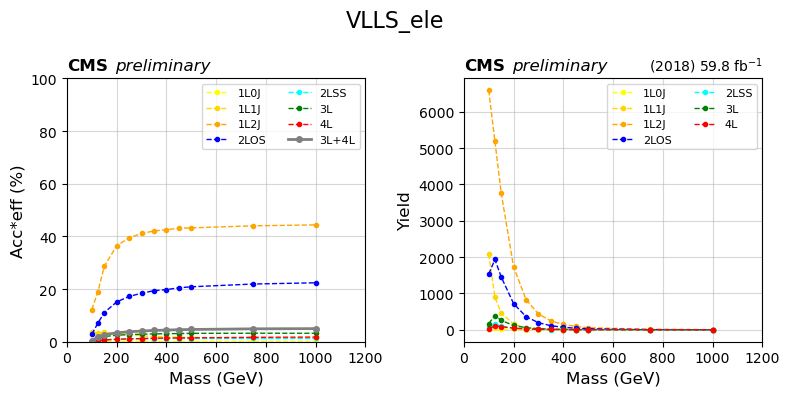

In [5]:
make_plot("VLLS_ele")

Yield (acceptance %) for VLLS_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	594746	104 (0.2%)	2050 (3.8%)	6623 (12.3%)	1633 (3.0%)	91 (0.2%)	235 (0.4%)	35 (0.1%)	
125	599690	61 (0.2%)	1058 (3.9%)	6448 (23.7%)	2793 (10.3%)	179 (0.7%)	476 (1.7%)	175 (0.6%)	
150	598660	28 (0.2%)	540 (4.1%)	4305 (32.6%)	1980 (15.0%)	100 (0.8%)	299 (2.3%)	127 (1.0%)	
200	599555	8 (0.2%)	162 (3.4%)	1845 (38.7%)	920 (19.3%)	41 (0.9%)	127 (2.7%)	58 (1.2%)	
250	496540	2 (0.1%)	57 (2.7%)	860 (40.8%)	454 (21.6%)	18 (0.9%)	62 (3.0%)	29 (1.4%)	
300	499438	1 (0.1%)	24 (2.3%)	443 (42.0%)	239 (22.7%)	9 (0.9%)	32 (3.0%)	16 (1.5%)	
400	198686	0 (0.1%)	6 (1.9%)	146 (42.9%)	82 (24.2%)	2 (0.9%)	11 (3.3%)	5 (1.7%)	
450	197673	0 (0.1%)	3 (1.7%)	91 (43.6%)	51 (24.4%)	1 (0.8%)	6 (3.2%)	3 (1.8%)	
500	199603	0 (0.1%)	2 (1.6%)	58 (43.5%)	33 (24.9%)	1 (0.8%)	4 (3.3%)	2 (1.8%)	
750	99672	0 (0.1%)	0 (1.4%)	10 (43.9%)	6 (26.1%)	0 (0.8%)	0 (3.4%)	0 (2.0%)	
1000	99496	0 (0.1%)	0 (1.4%)	2 (44.2%)	1 (26.6%)	0 (0.7%)	0 (

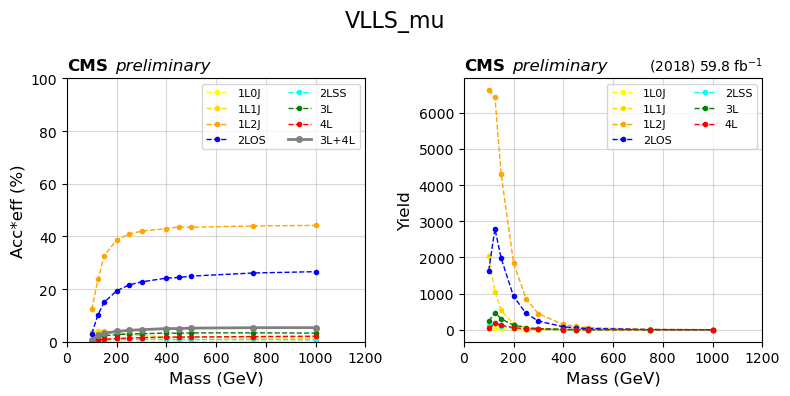

In [6]:
make_plot("VLLS_mu")

Yield (acceptance %) for VLLD_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	110871	1389 (0.2%)	14963 (1.9%)	75778 (9.8%)	62363 (8.1%)	22237 (2.9%)	27253 (3.5%)	3876 (0.5%)	
200	73730	44 (0.1%)	983 (1.6%)	18042 (29.5%)	24406 (39.9%)	2741 (4.5%)	6913 (11.3%)	1461 (2.4%)	
300	24753	4 (0.0%)	105 (0.8%)	3632 (27.1%)	6132 (45.7%)	582 (4.3%)	1794 (13.4%)	414 (3.1%)	
400	24491	1 (0.0%)	20 (0.5%)	1076 (25.0%)	2094 (48.7%)	192 (4.5%)	600 (14.0%)	144 (3.4%)	
600	24611	0 (0.0%)	3 (0.5%)	191 (25.4%)	360 (47.9%)	34 (4.6%)	108 (14.5%)	23 (3.2%)	
800	23680	0 (0.0%)	0 (0.2%)	40 (21.3%)	97 (51.4%)	8 (4.6%)	30 (16.2%)	7 (3.7%)	
1000	24286	0 (0.0%)	0 (0.2%)	11 (20.6%)	30 (52.2%)	2 (4.6%)	9 (15.9%)	2 (4.0%)	

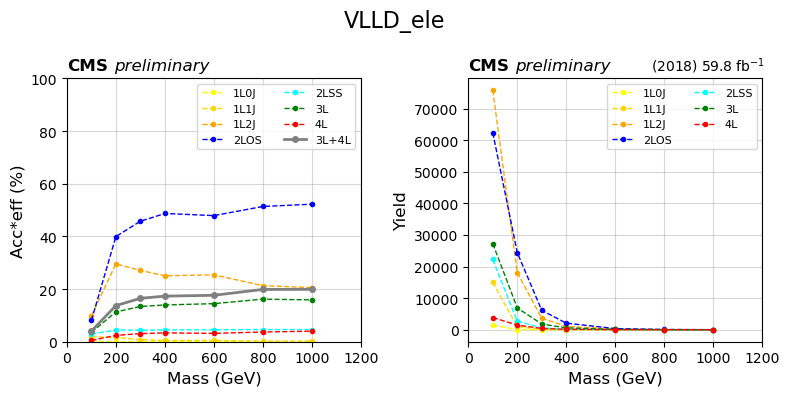

In [7]:
make_plot("VLLD_ele")

Yield (acceptance %) for VLLD_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	111926	1211 (0.2%)	14224 (1.8%)	89288 (11.6%)	104730 (13.6%)	22289 (2.9%)	52533 (6.8%)	7363 (1.0%)	
200	73908	47 (0.1%)	933 (1.5%)	11723 (19.2%)	33184 (54.3%)	1545 (2.5%)	9015 (14.8%)	2035 (3.3%)	
300	25022	1 (0.0%)	95 (0.7%)	2163 (16.1%)	7857 (58.6%)	302 (2.3%)	2224 (16.6%)	520 (3.9%)	
400	24299	0 (0.0%)	16 (0.4%)	585 (13.6%)	2619 (60.9%)	91 (2.1%)	762 (17.7%)	177 (4.1%)	
600	24890	0 (0.0%)	1 (0.2%)	91 (12.1%)	467 (62.1%)	14 (1.9%)	141 (18.7%)	32 (4.3%)	
800	24763	0 (0.0%)	0 (0.2%)	21 (11.2%)	119 (62.9%)	3 (1.8%)	35 (18.6%)	9 (4.8%)	

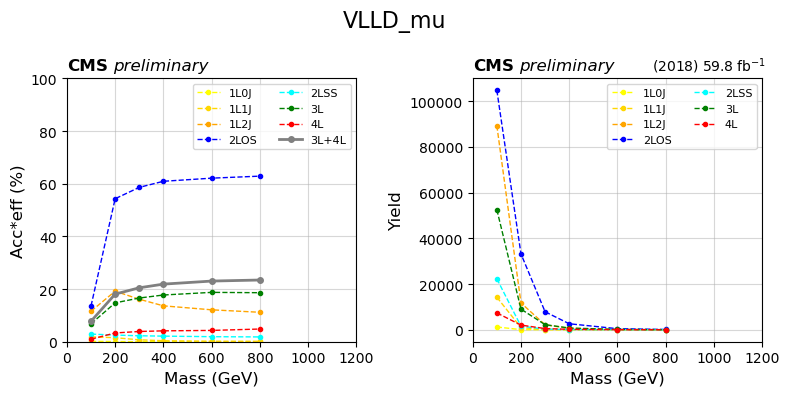

In [8]:
make_plot("VLLD_mu")